## 간단한 예측 실습만 진행
- 데이터 전처리
    - null 처리
    - 불필요한 속성 제거
    - 인코딩 수행
- 모델 학습 및 검증/예측/평가
    - 결정트리, 랜덤포레스트, 로지스틱 회귀 학습 비교
    - k 폴드 교차 검증
    - cross_val_score()와 GridSearchCV() 수행

In [1]:
# 필요 패키지 로드
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
# 데이터 로드
titanic_df = pd.read_csv('train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


- PassengerId : 탑승자 데이터 일련번호
- Survived : 생존 여부 0:사망, 1:생존
- Pclass : 티켓의 선실 등급, 1:일등석, 2:이등석, 3:삼등석
- Name : 탑승자 이름
- Sex : 탑승자 성별
- Age : 탑승자 나이
- SibSp : 같이 탑승한 형제자매 또는 배우자 인원수
- Parch : 같이 탑슨한 부모님 또는 어린이 인원수
- Ticket : 티켓 번호
- Fare : 요금
- Cabin : 선실 번호
- Embarked : 중간 정착 항구 C:Cherbourg, Q:Queenstown, S:Southampton

In [4]:
print('\n ### train 데이터 정보 ### \n')
print(titanic_df.info())


 ### train 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [8]:
# Null 컬럼들에 대한 처리
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)

print('데이터 세트 Null 값 개수 ', titanic_df.isnull().sum().sum())
# titanic_df.head(10)

데이터 세트 Null 값 개수  0


In [9]:
print('데이터 세트 Null 값 개수', titanic_df.isnull().sum())

데이터 세트 Null 값 개수 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [10]:
print(' Sex 값 분포 :\n', titanic_df['Sex'].value_counts())
print('\n Cabin 값 분포 :\n', titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포 :\n', titanic_df['Embarked'].value_counts())

 Sex 값 분포 :
 male      577
female    314
Name: Sex, dtype: int64

 Cabin 값 분포 :
 N              687
G6               4
C23 C25 C27      4
B96 B98          4
D                3
              ... 
E40              1
C106             1
B30              1
D7               1
C111             1
Name: Cabin, Length: 148, dtype: int64

 Embarked 값 분포 :
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [11]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1] # str로 해줘야함, Cabin에서 맨 앞에 알파벳 하나만 가져온다
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


In [13]:
pd.DataFrame(titanic_df.groupby(['Sex', 'Survived'])['Survived'].count())

Survived
Sex    Survived          
female 0               81
       1              233
male   0              468
       1              109

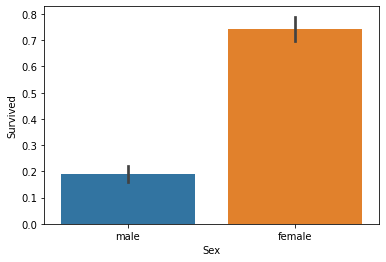

In [14]:
sns.barplot(x='Sex', y='Survived',data=titanic_df)

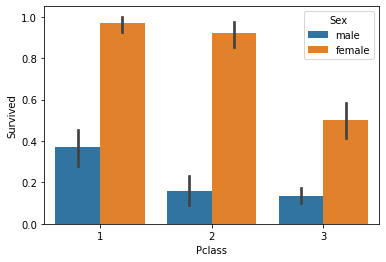

In [15]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

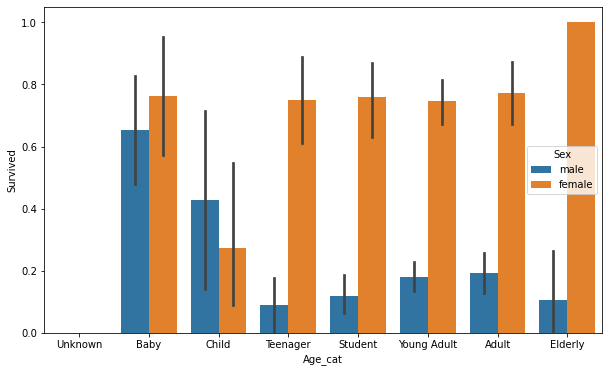

In [18]:
# 입력 age에 따라 구분값을 반환하는 함수 설정. DataFrame의 apply lambda 식에 사용
def get_category(age):
    cat=''
    if age <= -1 : 
        cat = 'Unknown'
    elif age <= 5 :
        cat = 'Baby'
    elif age <= 12 :
        cat = 'Child'
    elif age <= 18 :
        cat = 'Teenager'
    elif age <= 25 :
        cat = 'Student'
    elif age <= 35 :
        cat = 'Young Adult'
    elif age <= 60 :
        cat = 'Adult'
    else : 
        cat = 'Elderly'
    return cat

# 막대그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(10,6))

# X축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category() 함수를 반환값으로 지정
# get_category(X)는 입력값으로 'Age' 컬럼값을 받아서 해당하는 cat 밚환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y = 'Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)
        

In [24]:
from sklearn import preprocessing

def encode_features(dataDF) :
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features :
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


In [28]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df) :
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제고
def drop_features(df) :
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df) :
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features :
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df) :
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [36]:
# 원본 데이터를 재로딩 하고, feature데이터 셋과 Label 데이터 셋 추출
titanic_df = pd.read_csv('train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

X_titanic_df = transform_features(X_titanic_df)

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정 트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도 : {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도 : 0.7877
RandomForestClassifier 정확도 : 0.8547
LogisticRegression 정확도 : 0.8492


C:\Users\JAY\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    # 폴드 세트를 5개인 KFold 객체를 생성, 폴드 수만큼 예측결과 저장을 위한 리스트 객체 생성
    kfold = KFold(n_splits=folds)
    scores = []
    
    # KFold 교차 검증 수행
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)) :
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print('교차 검증 {0} 정확도 : {1:.4f}'.format(iter_count, accuracy))
        
    # 5개 fold에서의 평균 정확도 계산
    mean_score = np.mean(scores)
    print('평균 정확도 : {0:.4f}'.format(mean_score))
    
# exec_kfold 호출
exec_kfold(dt_clf, folds=5)

교차 검증 0 정확도 : 0.7542
교차 검증 1 정확도 : 0.7809
교차 검증 2 정확도 : 0.7865
교차 검증 3 정확도 : 0.7697
교차 검증 4 정확도 : 0.8202
평균 정확도 : 0.7823


In [47]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores) :
    print('교차 검증 {0} 정확도 : {1:.4f}'.format(iter_count, accuracy))
    
print('평균 정확도 : {0:.4f}'.format(np.mean(scores)))

교차 검증 0 정확도 : 0.7430
교차 검증 1 정확도 : 0.7753
교차 검증 2 정확도 : 0.7921
교차 검증 3 정확도 : 0.7865
교차 검증 4 정확도 : 0.8427
평균 정확도 : 0.7879


In [49]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth' : [2, 3, 5, 10],
              'min_samples_split' :[2,3,5],
              'min_samples_leaf' :[1,5,8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도 : {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도 : 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715
